# Policy Evaluation Examples

In [1]:
import sys
sys.path.append("../")

from blbf.STBT import STBT
from blbf.PolicyEvaluation import PolicyEvaluation 
import blbf.DataReader as DataReader
import blbf.utils as utils
import pandas as pd
import numpy as np
import sklearn.linear_model 
import seaborn as sns
import matplotlib.pyplot as plt

/Users/lguelman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Compare the following methods

* IPS: Inverse Propensity Score
* DM: Direct Method (Reward Prediction)
* DR: Doubly Robust
* SWITCH: Switch Estimator

In [2]:
class ComparePolicyEvaluation:
    
    def __init__(self, B: int = 100, datasets: list = None):
        self.B = B
        self.datasets = datasets
        
    def __repr__(self):
            
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))

    def fit_policies(self, **kwargs) -> pd.DataFrame:
        
        if self.datasets is None:
            self.datasets = ['ecoli', 'glass', 'lymphography', 'yeast', 
                        'digits', 'breast-cancer', 'wine'] # 'letter-recognition'
        dat = list()
        true_value = list()
        ips = list()
        dm = list()
        dr = list()
        switch = list()
        
        for s in self.datasets:
            for b in range(self.B):
                if (b % 10) == 0:
                    print("Sample: %d - Dataset: %s" % (b, s))
                X, y = DataReader.get_data(dataset=s)
                d = STBT().generate_batch(X, y, max_iter=1000)
                dat.append(s)
                true_value.append(d.true_target_value_test)
                ips.append(PolicyEvaluation(method='ips').evaluate_policy(data = d))
                dm.append(PolicyEvaluation(method='dm').evaluate_policy(data = d, **kwargs))
                dr.append(PolicyEvaluation(method='dr').evaluate_policy(data = d, **kwargs))
                switch.append(PolicyEvaluation(method='switch').evaluate_policy(data = d, **kwargs))
           
        res = pd.DataFrame.from_dict({'dataset':dat, 'true_value':true_value, 'ips':ips,
                                     'dm': dm, 'dr':dr, 'switch': switch})
    
        # Bias
        res['ips_bias'] = res['true_value'].values - res['ips'].values
        res['dm_bias'] = res['true_value'].values - res['dm'].values
        res['dr_bias'] = res['true_value'].values - res['dr'].values
        res['switch_bias'] = res['true_value'].values - res['switch'].values
        
        # Relative risk
        res['ips_rr'] = np.abs((res['true_value'].values - res['ips'].values)/res['true_value'].values)
        res['dm_rr'] = np.abs((res['true_value'].values - res['dm'].values)/res['true_value'].values)
        res['dr_rr'] = np.abs((res['true_value'].values - res['dr'].values)/res['true_value'].values)
        res['switch_rr'] = np.abs((res['true_value'].values - res['switch'].values)/res['true_value'].values)
        
        self.res = res
       
        return self
    
    def get_summary_stats(self):
        
        res_summary = self.res.groupby(['dataset'], as_index=False).agg({
                            'ips_bias': ['mean','std'], 
                            'dm_bias': ['mean','std'],
                            'dr_bias': ['mean','std'],
                            'switch_bias': ['mean','std'],
                            'ips_rr': ['mean','std'], 
                            'dm_rr': ['mean','std'],
                            'dr_rr': ['mean','std'],
                            'switch_rr': ['mean','std']
                            })
        
        self.res_summary = res_summary
        return self
    
    def plot_bias(self):
        
        res_long = pd.melt(self.res, id_vars=['dataset'], var_name = 'method', value_name = "bias",
                  value_vars=['ips_bias',  'dm_bias', 'dr_bias', 'switch_bias'])

        ax = sns.catplot(x="method", y="bias", col = "dataset", kind = "box", 
                          col_wrap=3, data=res_long)
        for i in range(len(ax.axes)):
            ax_i = ax.axes[i]
            ax_i.axhline(0, ls="--")
        
        plt.show()

In [3]:
cpe = ComparePolicyEvaluation(B=100).fit_policies(max_iter=1000)

Sample: 0 - Dataset: ecoli
Sample: 10 - Dataset: ecoli
Sample: 20 - Dataset: ecoli
Sample: 30 - Dataset: ecoli
Sample: 40 - Dataset: ecoli
Sample: 50 - Dataset: ecoli
Sample: 60 - Dataset: ecoli
Sample: 70 - Dataset: ecoli
Sample: 80 - Dataset: ecoli
Sample: 90 - Dataset: ecoli
Sample: 0 - Dataset: glass
Sample: 10 - Dataset: glass
Sample: 20 - Dataset: glass
Sample: 30 - Dataset: glass
Sample: 40 - Dataset: glass
Sample: 50 - Dataset: glass
Sample: 60 - Dataset: glass
Sample: 70 - Dataset: glass
Sample: 80 - Dataset: glass
Sample: 90 - Dataset: glass
Sample: 0 - Dataset: lymphography
Sample: 10 - Dataset: lymphography
Sample: 20 - Dataset: lymphography
Sample: 30 - Dataset: lymphography
Sample: 40 - Dataset: lymphography
Sample: 50 - Dataset: lymphography
Sample: 60 - Dataset: lymphography
Sample: 70 - Dataset: lymphography
Sample: 80 - Dataset: lymphography
Sample: 90 - Dataset: lymphography
Sample: 0 - Dataset: yeast
Sample: 10 - Dataset: yeast
Sample: 20 - Dataset: yeast
Sample: 30

In [4]:
cpe.get_summary_stats()
cpe.res_summary   

dataset  ips_bias             dm_bias             dr_bias            \
                      mean       std      mean       std      mean       std   
0  breast-cancer -0.002491  0.056349  0.030196  0.014519 -0.000332  0.009850   
1         digits -0.009555  0.098520  0.268479  0.037697 -0.003268  0.045177   
2          ecoli  0.032619  0.154158  0.206961  0.065328  0.007370  0.086709   
3          glass -0.026075  0.153120  0.123257  0.088315 -0.025040  0.121061   
4   lymphography  0.023919  0.163914  0.209962  0.110058  0.006883  0.092575   
5           wine  0.011910  0.135612  0.122779  0.041927  0.004703  0.038939   
6          yeast  0.003976  0.071053  0.081091  0.043260  0.006857  0.060082   

  switch_bias              ips_rr               dm_rr               dr_rr  \
         mean       std      mean       std      mean       std      mean   
0   -0.000332  0.009850  0.047370  0.035570  0.031742  0.015077  0.008327   
1   -0.003268  0.045177  0.081028  0.068970  0.289145  0.040453  0.036532   
2    0.007370  0.086709  0.167267  0.115022  0.267403  0.080937  0.087567   
3   -0.025040  0.121061  0.248548  0.188399  0.259093  0.157486  0.210020   
4    0.006883  0.092575  0.177519  0.125696  0.274405  0.138186  0.094473   
5    0.004703  0.038939  0.118398  0.084967  0.131240  0.043784  0.034367   
6    0.006857  0.060082  0.122386  0.098187  0.178098  0.091898  0.103003   

            switch_rr            
        std      mean       std  
0  0.006122  0.008327  0.006122  
1  0.032018  0.036532  0.032018  
2  0.070481  0.087567  0.070481  
3  0.136871  0.210020  0.136871  
4  0.075702  0.094473  0.075702  
5  0.024248  0.034367  0.024248  
6  0.083534  0.103003  0.083534

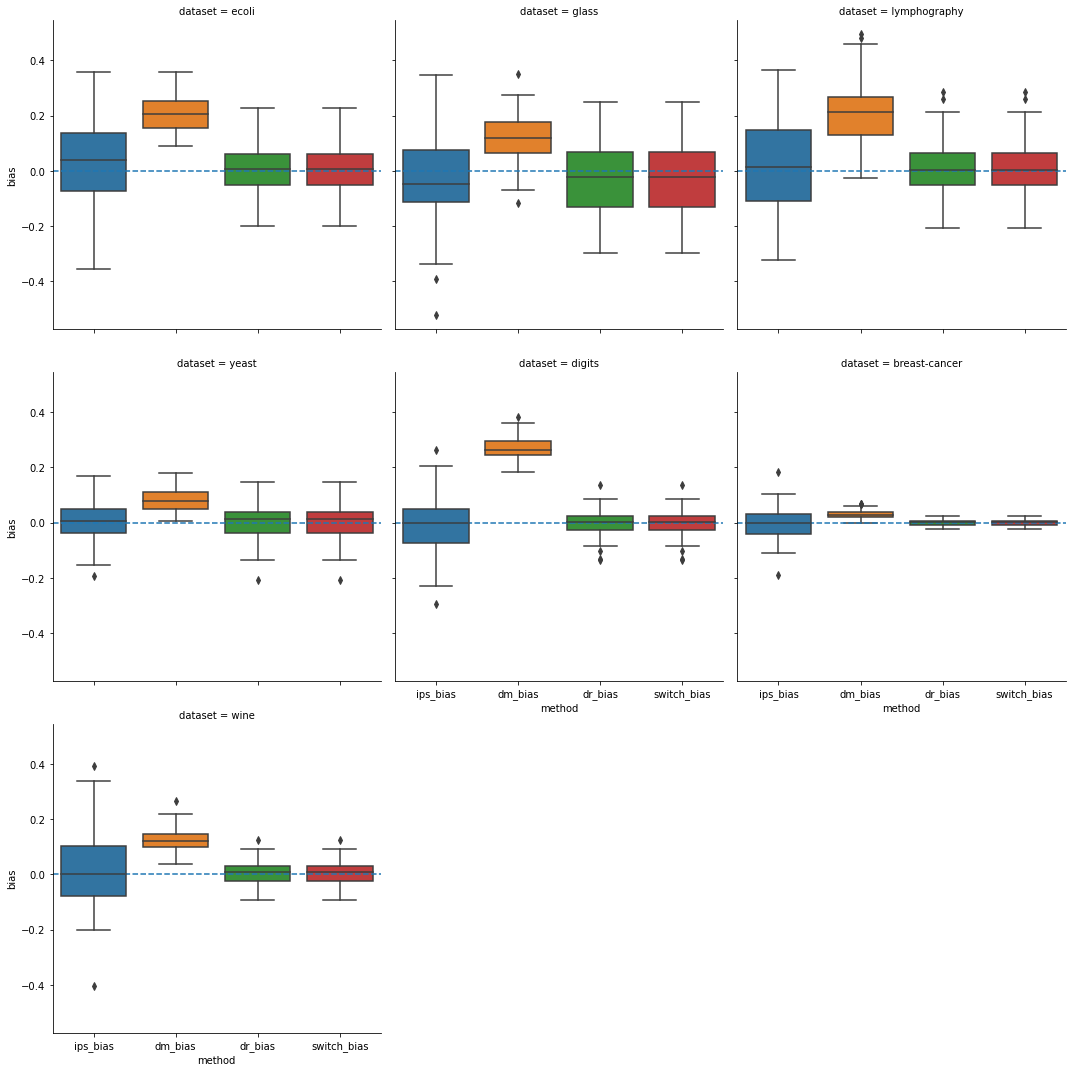

In [5]:
cpe.plot_bias()